In [75]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline


output_dir = 'TimeSeries\\Benchmarks\\bin\\Debug'

benchmarks = [
    'rawdata-CasTimeSeries with bulk write-Read and write.json',
    'rawdata-CasTimeSeries with bulk write-Read only.json',
    'rawdata-CasTimeSeries with bulk write-Write only.json',
    
    'rawdata-CasTimeSeries with single write-Read and write.json',
    'rawdata-CasTimeSeries with single write-Read only.json',
    'rawdata-CasTimeSeries with single write-Write only.json',
    
    'rawdata-AllBoxEventSeriesWrapper with bulk write-Read and write.json',
    'rawdata-AllBoxEventSeriesWrapper with bulk write-Read only.json',
    'rawdata-AllBoxEventSeriesWrapper with bulk write-Write only.json',
    
    'rawdata-AllBoxEventSeriesWrapper with single write-Read and write.json',
    'rawdata-AllBoxEventSeriesWrapper with single write-Read only.json',
    'rawdata-AllBoxEventSeriesWrapper with single write-Write only.json',
]

benchmarks = [path.join(output_dir, x) for x in benchmarks]

In [35]:
import json

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [76]:
data = load_json(benchmarks[9])

In [69]:
def plot(workers_stats):
    show(workers_stats, lambda p, w: p.plot(w))


def hist(workers_stats, width=100):
    show(workers_stats, lambda p, w: p.hist(w, width))
    

def show(workers_stats, show_func):
    figure, subplots = plt.subplots(len(workers_stats), 1)

    figure.set_figheight(20)
    figure.set_figwidth(20)

    for worker, plot in zip(workers_stats, subplots):
        show_func(plot, worker)

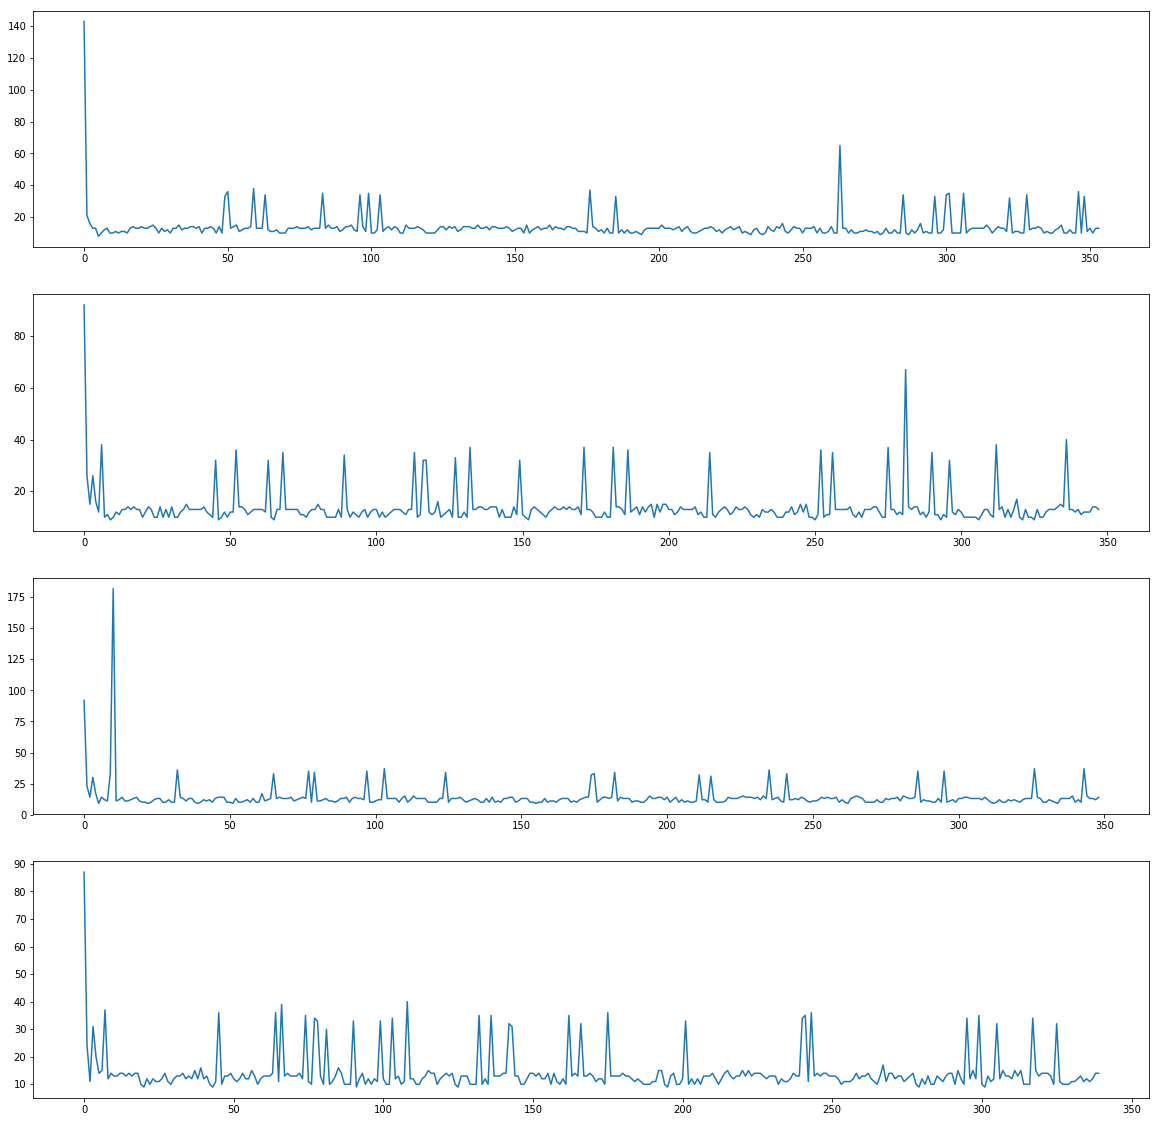

In [77]:
plot(data['Write']['Latency'])

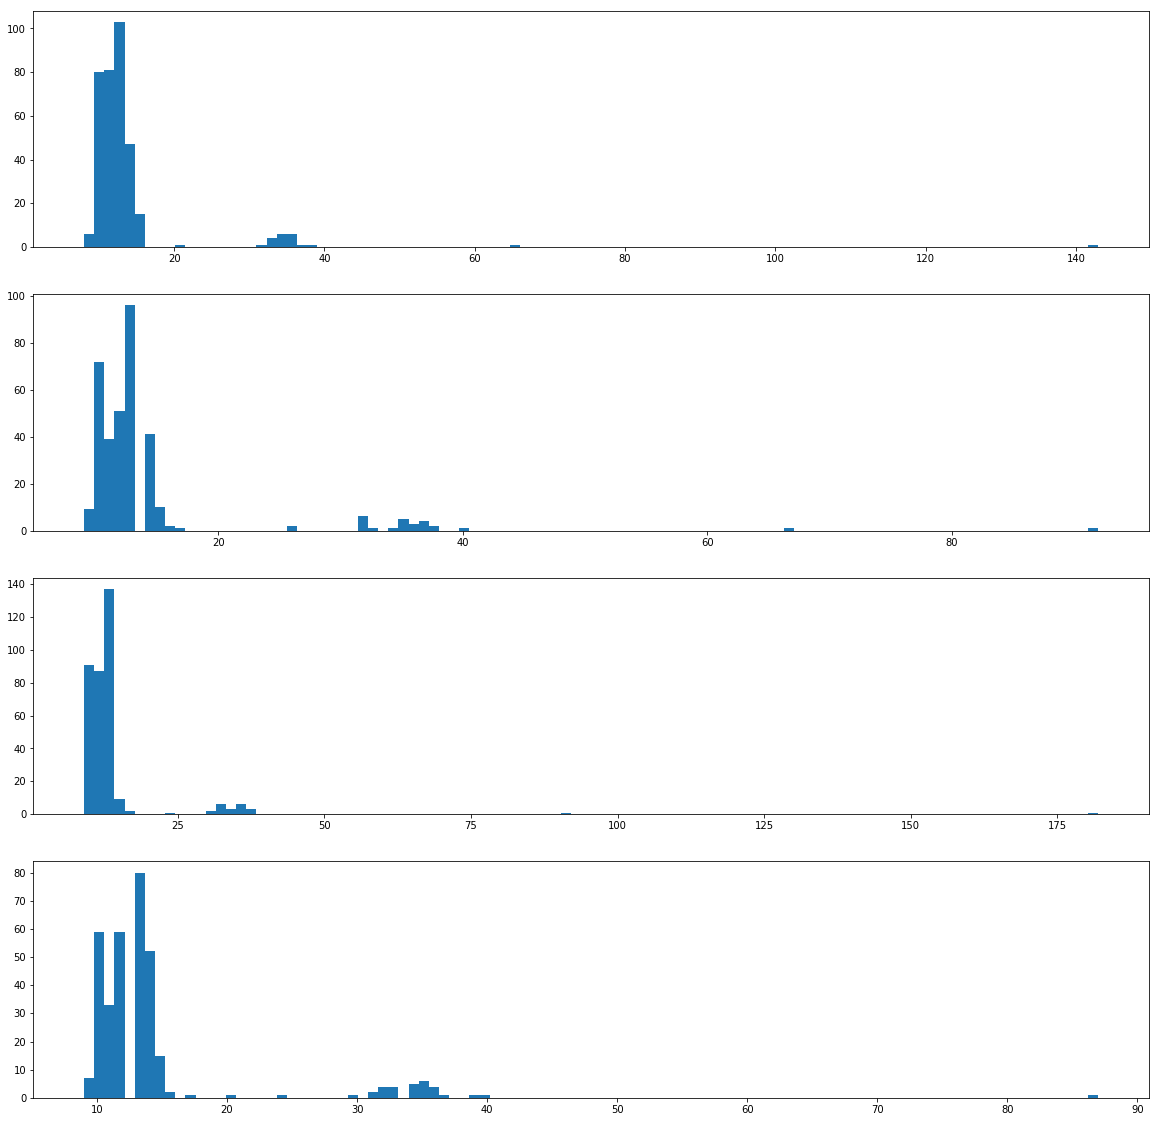

In [78]:
hist(data['Write']['Latency'])